## 0. 목표 및 방향성
train 데이터를 활용하여 test 데이터의 price를 예측하는 모델을 만듭니다.  
price는 집을 구매한 날을 기준이므로 시간에 따라 변화된 데이터가 있다면 집을 구매한 날짜를 기준으로 데이터를 선정하여 분석을 진행합니다.


In [229]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

print('Done')

Done


In [230]:
data_dir = os.getenv('HOME')+'/aiffel/exp6/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/exp6/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/exp6/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미 파악합니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [231]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [232]:
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [233]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [234]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## 2. 전처리 
각 변수들에 대해 결측 유무 및 분포를 확인하고 필요한 전처리 진행합니다.
### 결측치 확인

<AxesSubplot:>

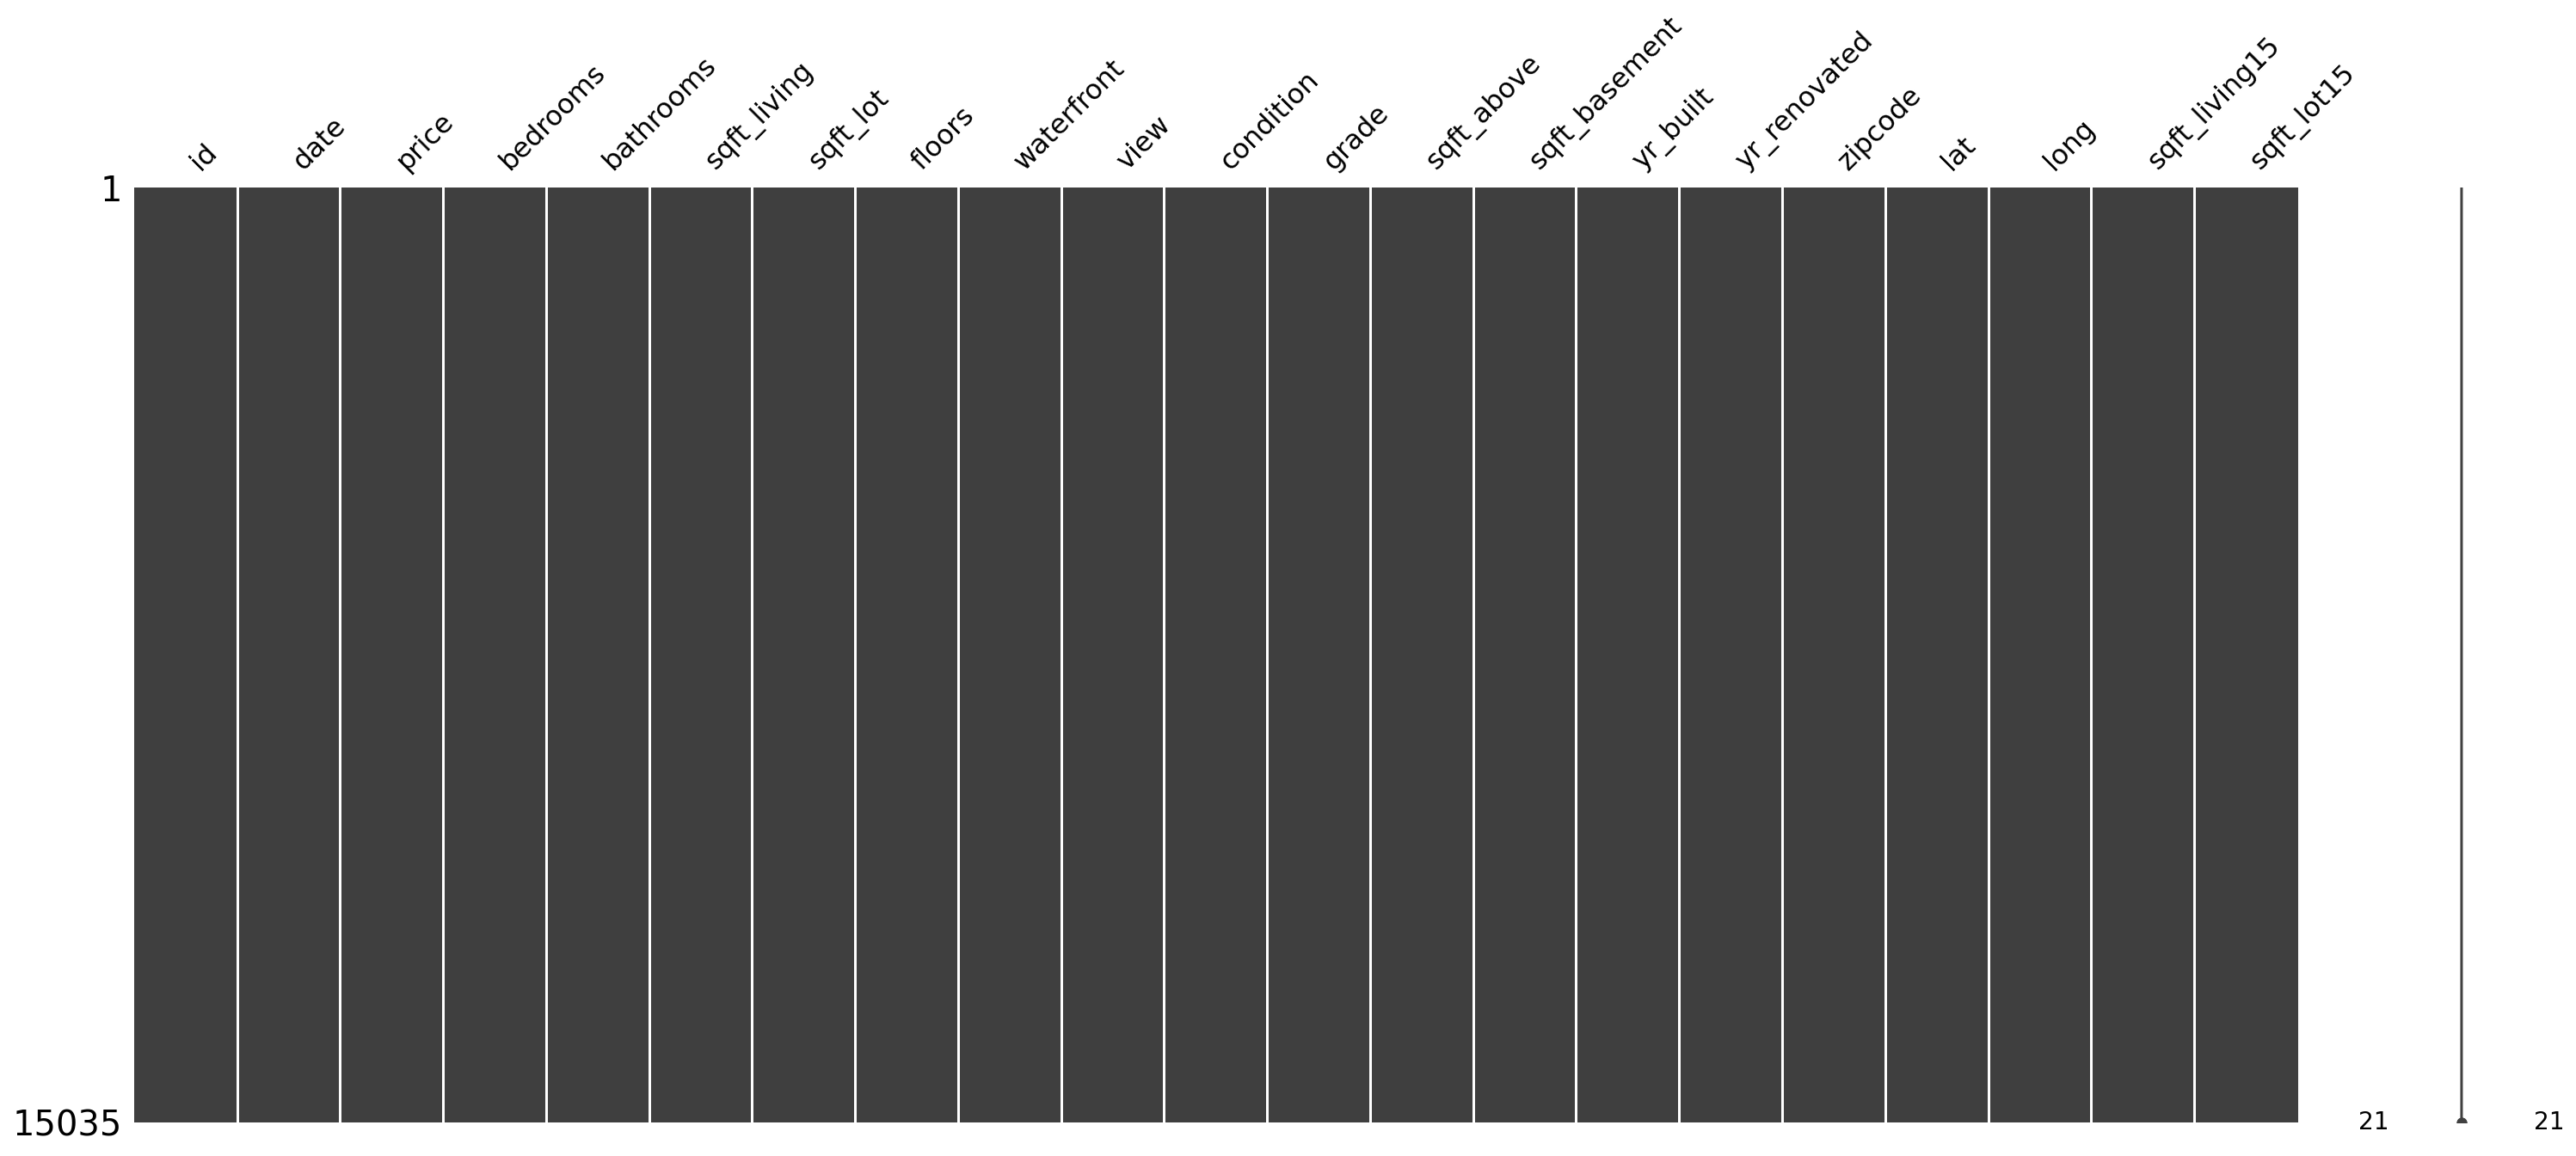

In [235]:
msno.matrix(data)

결측값이 없어 결측치에 대한 전처리가 필요 없음을 확인했습니다. 
  

In [236]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.  
date에 불필요한 문자가 붙어 있으므로 그것도 정리해줍니다.   
yr_renovated의 경우 토지면적과 주거면적에 변화가 있었음에도 리모델링에 대한 기록이 없는 집이 많았습니다.  
따라서 주거면적의 변화가 있을 경우에 리모델링으로 정의하고 이를 새로운 변수 renovated로 기록하기로 했습니다. 
토지면적을 고려하지 않은 이유는 같은 건축면적안에서 리모델링하여 토지면적의 변화는 없이 주거면적만 변화한 경우가 있기 때문입니다.  
이러한 리모델링 진행 유무는 15년도를 기준으로 하기에 만약 집의 구매일자가 2015년 전이라면 집 구매 당시에는 리모델링이 진행되지 않은 것으로 처리합니다.  
sqft_living과 sqft_lot의 경우 기록 날짜를 정확히 알 수 없어 어떻게 전처리를 진행해야할지 감이 잡히지 않았으나, 기본적으로 구매일인 date를 기준으로 데이터가 기록되었다는 점을 보아 sqft_living과 sqft_lot도 마찬가지로 구매일 기준으로 기록된 데이터라고 생각했습니다.
따라서 sqft_living15와 sqft_lot15는 구매 시점의 가격을 예측하는 데에는 필요 없는 데이터라고 할 수 있습니다.    
주거면적은 집 전체의 주거면적을 나타내기에 층 수가 높아지면 주거면적도 많이 늘어나는 경향이 있습니다. 
층수에는 지하실이 포함되어 있지 않으니 평균적인 층별 주거면적 계산을 위해 sqft_above를 floors로 나눠 층별 면적으로써 변수로 추가해줬습니다.
토지면적 대비 주택이 차지하는 영역의 비율을 구하기 위해 위에서 얻은 값을 sqft_lot으로 나눠줍니다.
주거면적 대비 지하실의 크기 또한 실용적인 다용도실로서 집값 결정 요인이 될 수 있는 만큼 sqft_basement를 sqft_living으로 나눠 파생변수를 생성합니다.

In [237]:
train_len = len(data)
del data['id']
data['date'] = data['date'].apply(lambda i: i[:8]).astype(int)
data['living_difference'] = data['sqft_living'] - data['sqft_living15']
data['renovated'] = data['living_difference'].apply(lambda i: 0 if i == 0 else 1)
data['renovated_before_purchse'] = np.where(data['date'] < 20150101, data['renovated'], 0)
data['sqft_per_floor'] = data['sqft_above'] / data['floors']
data['house_lot_ratio'] = data['sqft_per_floor'] / data['sqft_lot']
data['basement_ratio'] = data['sqft_basement'] / data['sqft_living']
del data['renovated']
del data['living_difference']
del data['yr_renovated']
del data['sqft_living15']
del data['sqft_lot15']

In [238]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,zipcode,lat,long,renovated_before_purchse,sqft_per_floor,house_lot_ratio,basement_ratio
0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,98178,47.5112,-122.257,1,1180.0,0.208850,0.0
1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,98028,47.7379,-122.233,0,770.0,0.077000,0.0
2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,98074,47.6168,-122.045,0,1680.0,0.207921,0.0
3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,1715,0,1995,98003,47.3097,-122.327,1,857.5,0.125752,0.0
4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,1060,0,1963,98198,47.4095,-122.315,0,1060.0,0.109155,0.0


In [239]:
data.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,zipcode,lat,long,renovated_before_purchse,sqft_per_floor,house_lot_ratio,basement_ratio
count,1.503500e+04,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,...,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,2.014387e+07,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,...,1794.158164,289.632059,1971.100432,98078.031726,47.560721,-122.213677,0.599268,1236.351158,0.177298,0.123705
std,4.425131e+03,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,...,831.738609,440.663284,29.407612,53.297815,0.138164,0.141294,0.490063,446.092404,0.103540,0.170307
min,2.014050e+07,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,290.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,0.000000,253.333333,0.000787,0.000000
25%,2.014072e+07,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,...,1190.000000,0.000000,1951.000000,98033.000000,47.472700,-122.328000,0.000000,940.000000,0.113542,0.000000
50%,2.014102e+07,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,...,1570.000000,0.000000,1975.000000,98065.000000,47.571900,-122.231000,1.000000,1180.000000,0.161814,0.000000
75%,2.015021e+07,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,...,2230.000000,550.000000,1997.000000,98117.000000,47.678300,-122.126000,1.000000,1460.000000,0.225126,0.269231
max,2.015051e+07,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,9410.000000,4130.000000,2015.000000,98199.000000,47.777600,-121.315000,1.000000,4610.000000,3.102564,0.666667


### 각 변수들의 분포 확인

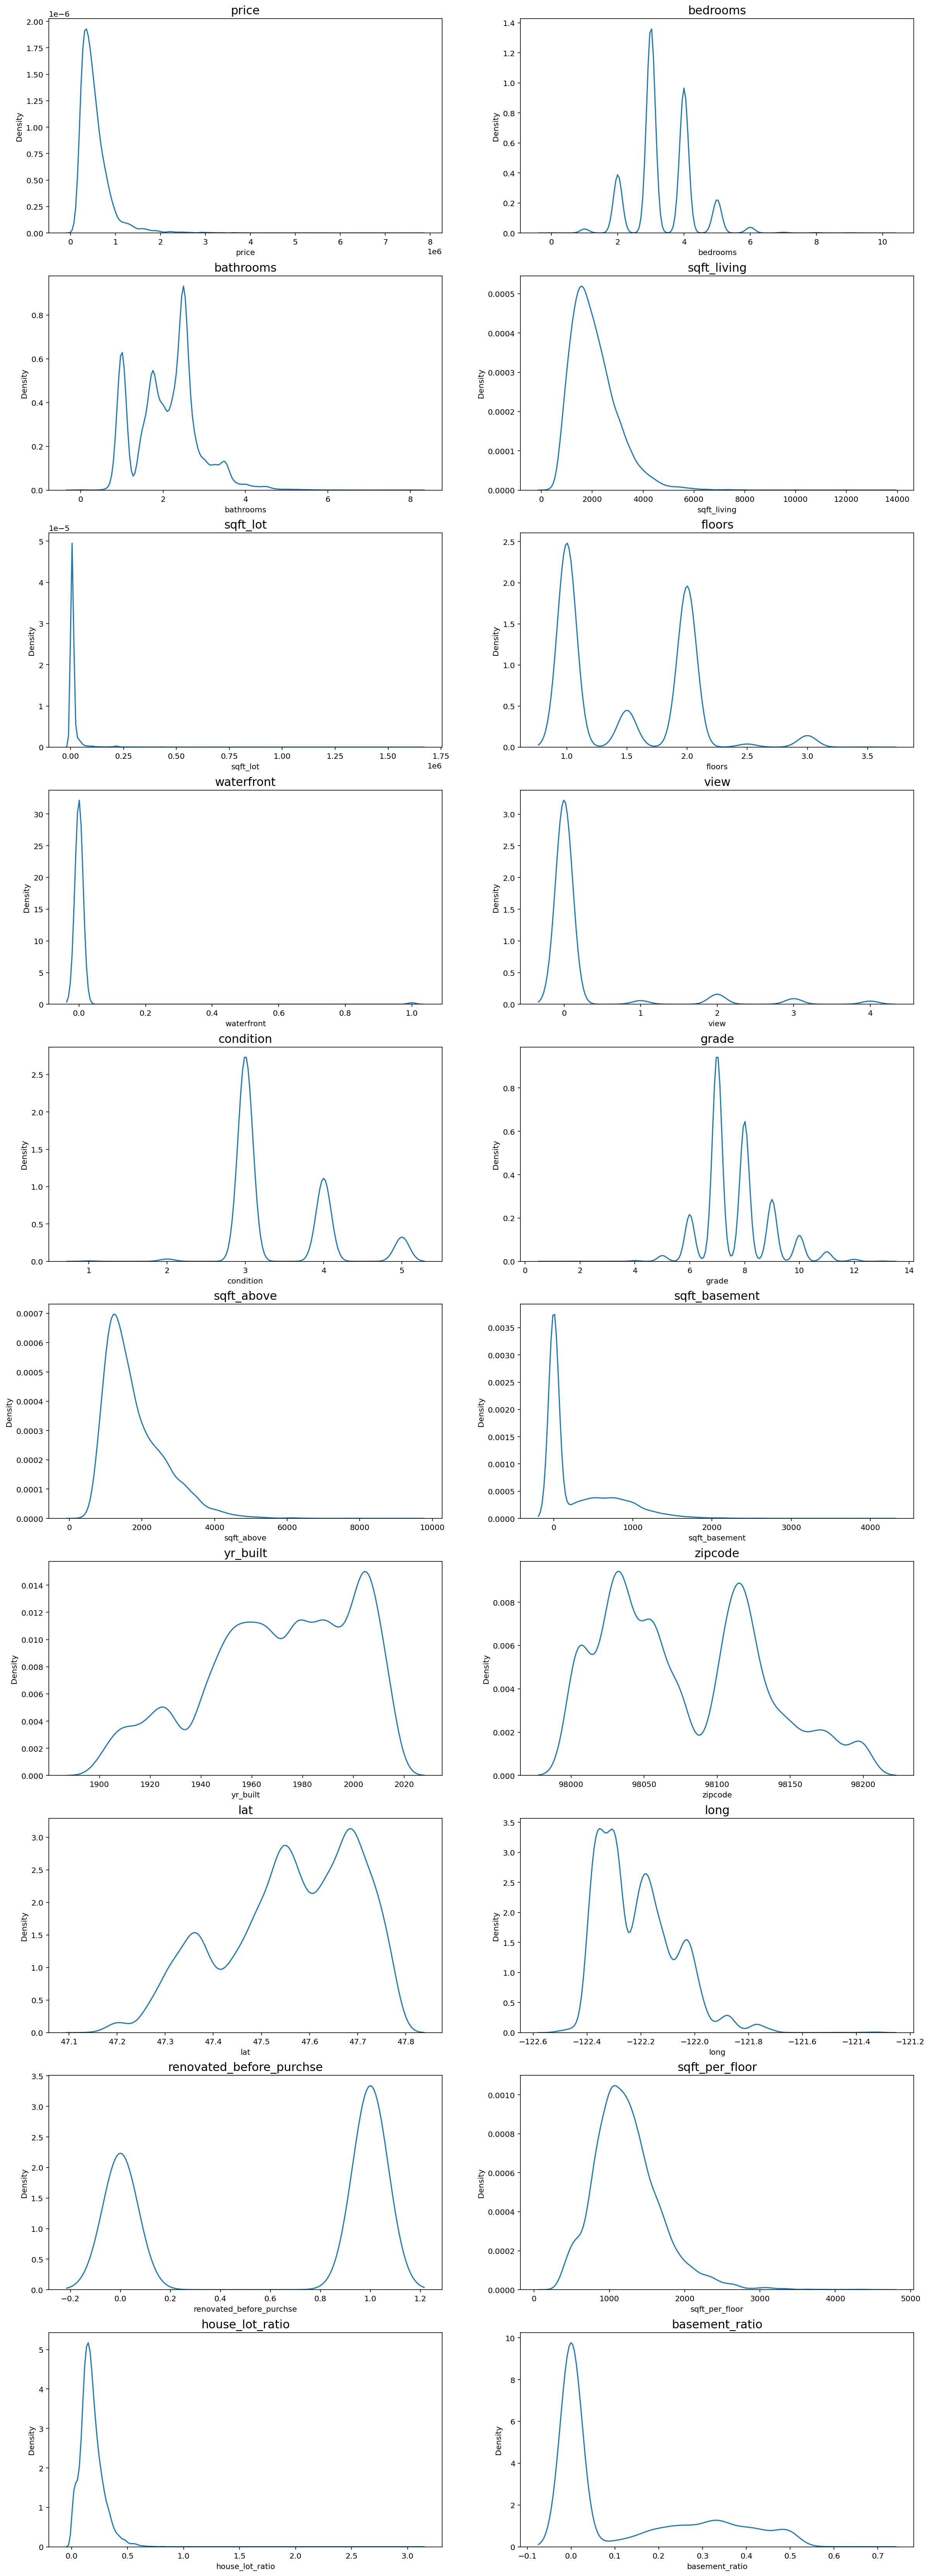

In [240]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 1
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 21 :
            break

price, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_per_floor, house_lot_ratio, basement_ratio 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
로그 변환을 통해 데이터 분포를 변형할 필요가 있다고 판단됩니다.  

In [241]:
skew_columns = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_per_floor', 'house_lot_ratio', 'basement_ratio']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

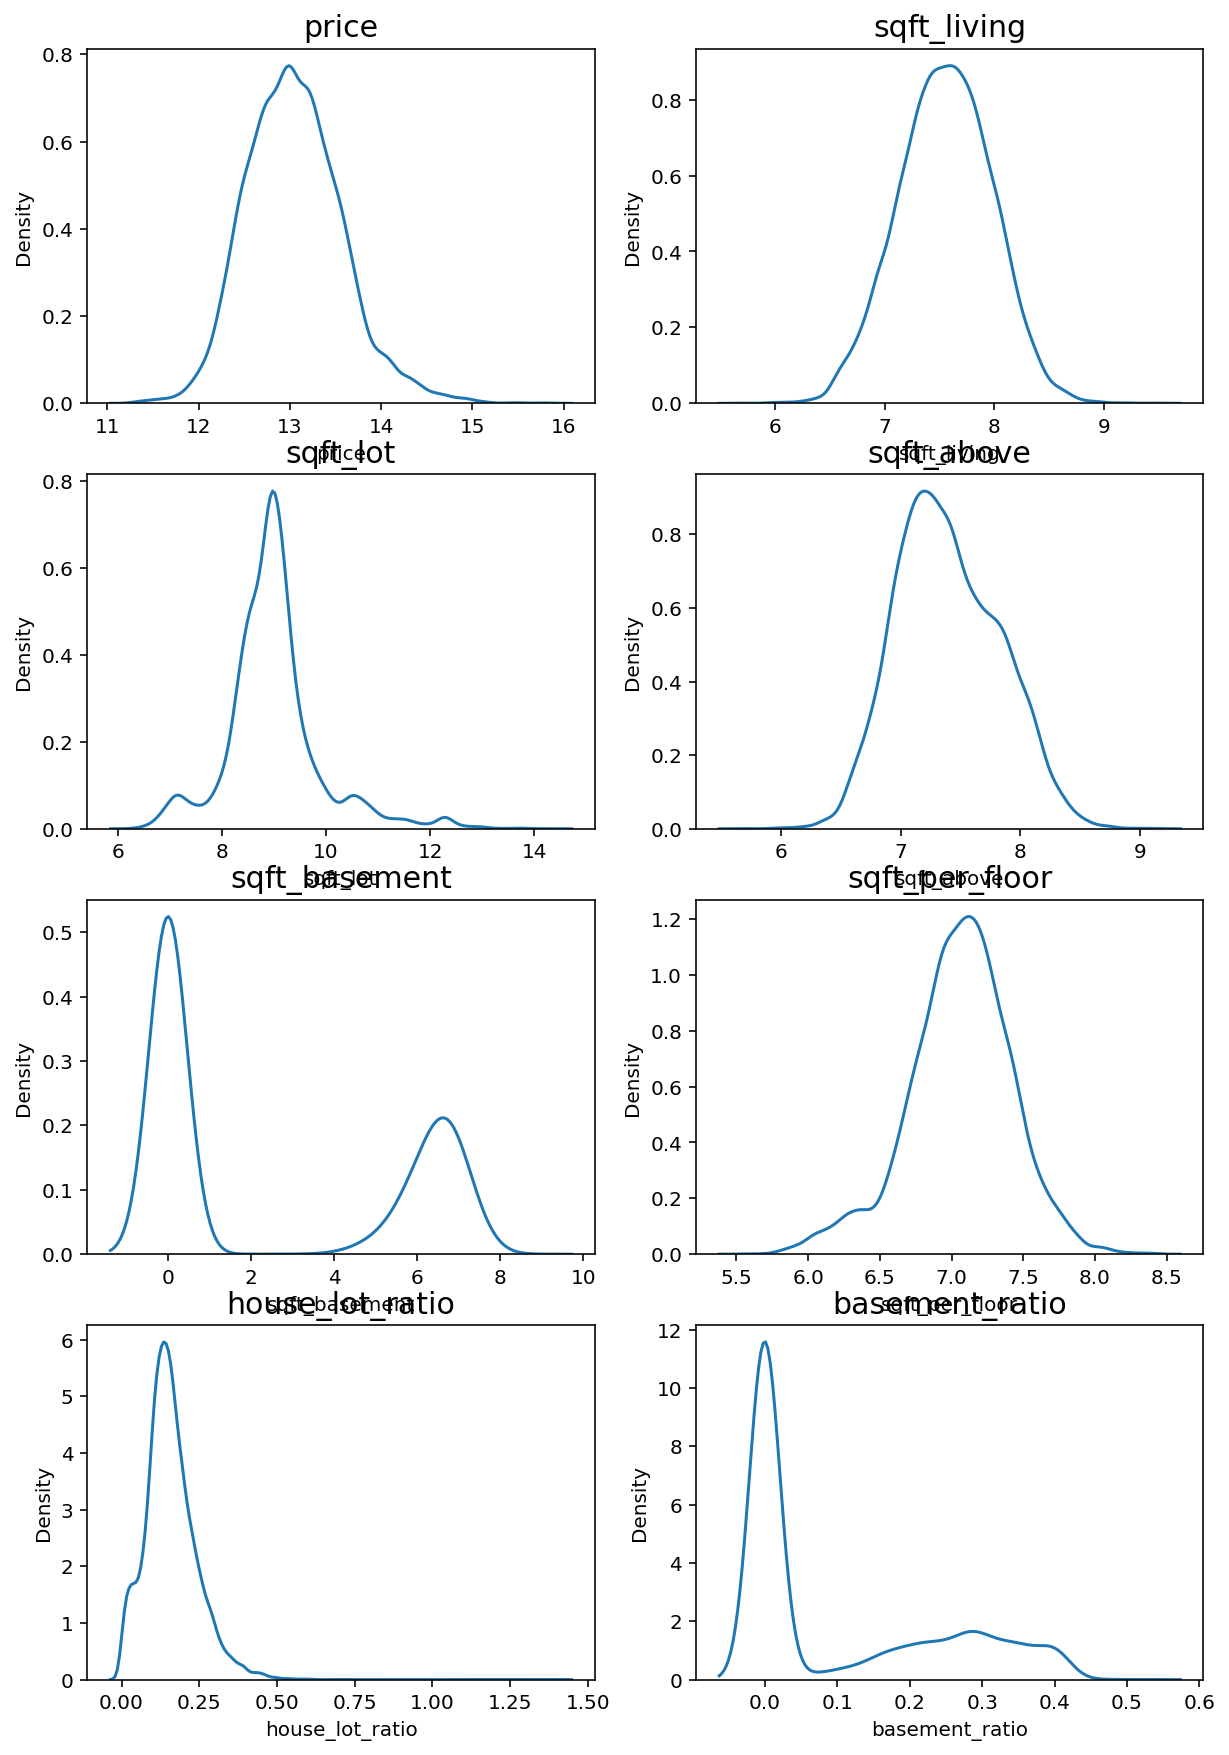

In [242]:
fig, ax = plt.subplots(4, 2, figsize=(10, 15))

count = 0
for row in range(4):
    for col in range(2):
        if count == 8:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

target인 price를 y로 저장하고 나머지 독립변수들을 x에 저장합니다.

In [243]:
y = data['price']

del data['price']

x = data.iloc[:train_len, :]

test 데이터에 대해서도 train 데이터와 동일한 전처리를 진행해줍니다.  
test 데이터에는 target 변수인 price가 없기에 그 부분은 제외하고 전처리를 진행합니다.

In [244]:
test_data_path = join(data_dir, 'test.csv')
test = pd.read_csv(test_data_path)

del test['id']
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
test['living_difference'] = test['sqft_living'] - test['sqft_living15']
test['renovated'] = test['living_difference'].apply(lambda i: 0 if i == 0 else 1)
test['renovated_before_purchse'] = np.where(test['date'] < 20150101, test['renovated'], 0)
test['sqft_per_floor'] = test['sqft_above'] / test['floors']
test['house_lot_ratio'] = test['sqft_per_floor'] / test['sqft_lot']
test['basement_ratio'] = test['sqft_basement'] / test['sqft_living']
del test['renovated']
del test['living_difference']
del test['yr_renovated']
del test['sqft_living15']
del test['sqft_lot15']

skew_columns_test = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_per_floor', 'house_lot_ratio', 'basement_ratio']

for c in skew_columns_test:
    test[c] = np.log1p(test[c].values)

In [245]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,renovated_before_purchse,sqft_per_floor,house_lot_ratio,basement_ratio
0,20141209,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,98125,47.7210,-122.319,1,6.990257,0.139606,0.144656
1,20141209,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,98136,47.5208,-122.393,1,6.957497,0.190620,0.381368
2,20140512,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,98053,47.6561,-122.005,1,8.266421,0.037453,0.248646
3,20150415,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,98146,47.5123,-122.337,0,6.957497,0.131521,0.343669
4,20150312,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,98038,47.3684,-122.031,0,6.852243,0.134579,0.000000


## 3. 모델링
다양한 앙상블 기법을 사용하여 각 기법에 따른 RMSE를 도출, 가장 뛰어난 모델을 선정합니다.

In [246]:
random_state=7

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [247]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [248]:
def get_scores(models, x, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=random_state, test_size=0.2)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        df[model_name] = rmse(y_val, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [249]:
get_scores(models, x, y)

,RMSE
GradientBoostingRegressor,132626.280967
RandomForestRegressor,126838.287241
XGBRegressor,117467.751129
LGBMRegressor,112341.701473


## LGBMRegressor 하이퍼파리미터 튜닝
LGBM의 RMSE가 가장 낮은 것으로 나와 이를 기준으로 하이퍼파라미터 튜닝을 진행합니다.
하이퍼파하미터 튜닝으로 num_leaves, learning_rate, num_iterations, max_depth, n_estimators, boosting 등을 고려하였습니다.
boosting의 경우 gridsearch 결과, default 값인 gbdt와 비교하여 dart와 goss가 유의미한 차이를 만들지 못 해 default로 두고 하이퍼파라미터 튜닝을 다시 진행했습니다.
한 번에 모든 계산을 하지 않고 뛰어난 값을 기준으로 하이퍼파리미터의 범위를 조절해 가며 다양한 조합에 대해 gridsearch를 진행했습니다.

In [250]:
param_grid = {'num_leaves': [32],
    'learning_rate': [0.02],
    'num_iterations': [1500, 1600, 1700],
    'max_depth': [8, 9, 10, 11, 12],
    'n_estimators': [3000]}
model = LGBMRegressor(random_state=random_state)
def my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(x, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed:  3.3min finished


,learning_rate,max_depth,n_estimators,num_iterations,num_leaves,score,RMSLE
9,0.02,11,3000,1500,32,-0.026432,0.162578
12,0.02,12,3000,1500,32,-0.026443,0.162614
13,0.02,12,3000,1600,32,-0.026446,0.162621
14,0.02,12,3000,1700,32,-0.026454,0.162646
10,0.02,11,3000,1600,32,-0.026455,0.162651
1,0.02,8,3000,1600,32,-0.026460,0.162666
11,0.02,11,3000,1700,32,-0.026461,0.162668
8,0.02,10,3000,1700,32,-0.026462,0.162673
2,0.02,8,3000,1700,32,-0.026464,0.162678
0,0.02,8,3000,1500,32,-0.026464,0.162678


## 4. 제출

In [227]:
def save_submission(model, x, y, test, model_name, rmsle=None):
    model.fit(x, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/exp6/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}_revised.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [251]:
model = LGBMRegressor(num_leaves=32,learning_rate=0.02, max_depth=11, n_estimators=3000, num_iterations=1500, random_state=random_state)

save_submission(model, x, y, test, 'lgbm', rmsle='0.162578')

/aiffel/aiffel/exp6/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.162578_revised.csv saved!


In [1]:
from IPython.display import Image

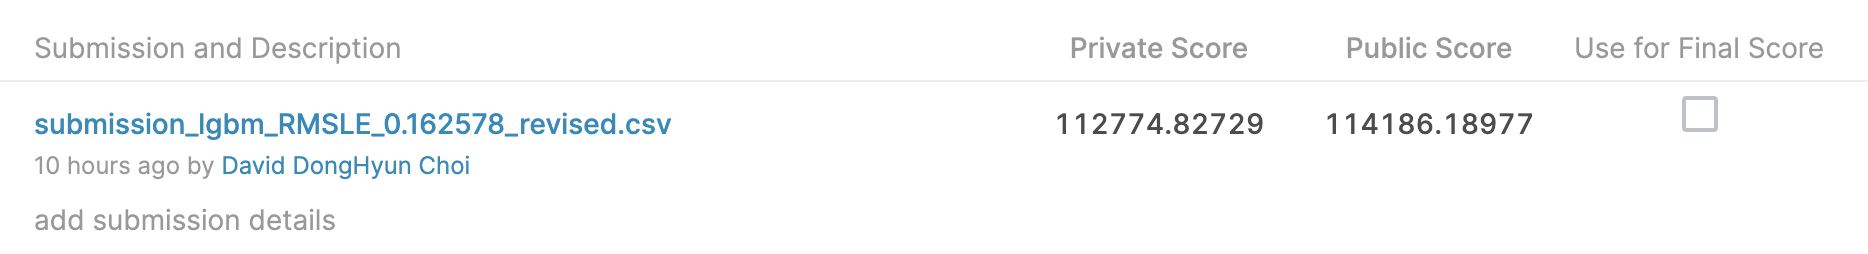

In [6]:
Image('/aiffel/aiffel/exp6/kaggle_kakr_housing/submission_result.png')

## 5. 결과 및 고찰
Private Score 112774점으로 목표치인 110000점에 상당히 근접했으나 결과적으로 도달하지는 못 했습니다.  
다양한 전처리 과정과 하이퍼파라미터 튜닝을 통해서 초기에 비해 유의미한 점수 개선이 있었다는 것에 의의를 두고 싶습니다.  
이 과정에서 하이퍼파라미터 튜닝을 통한 점수 개선폭은 생각보다 드라마틱하지 않았습니다.  
반대로 프로젝트를 진행하면서 층별면적을 변수로 추가했을 때 의외로 점수 개선이 컸던 것을 확인할 수 있었습니다.  
아마 주어진 자료에서 유의미한 파생변수를 더 찾아낼 수 있다면 더 큰 폭의 점수 개선을 이룰 수 있으리라 예상합니다.  
이를 통해 기본적으로 하이퍼파라미터튜닝 이전에 데이터전처리가 큰맥락에서 결과 개선에 더 큰 영향을 미친다는 것을 확인할 수 있었습니다.